## Initial Notebook

In [106]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
import seaborn as sns
from pydataset import data
import matplotlib.pyplot as plt
import math

from scipy import stats
import explore
import wrangle
import zillow_wrangle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import decimal as d

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")




---------------------------

predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.



We would like to know what states and counties these are located in.
We'd also like to know the distribution of tax rates for each county.

The data should have the tax amounts and tax value of the home, so it shouldn't be too hard to calculate.


Please include in your report to us the distribution of tax rates for each county so that we can see how much they vary within the properties in the county and the rates the bulk of the properties sit around.

Note that this is separate from the model you will build, because if you use tax amount in your model, you would be using a future data point to predict a future data point, and that is cheating! 
- In other words, for prediction purposes, we won't know tax amount until we know tax value.


-----------------------------------------------------

First pass is our MVP

- Acquire: whatever SQL query gives us workable data
- Prepare: drop nulls, data split
- Explore: visualize the target against independent variables
- Model: baseline, LinearRegression, LassoLars compare performance with rmse on validate
- NB. not worried about scaling or automated feature engineering

## Planning:



#### Goal: leave this section with (at least the outline of) a plan for the project documented in your README.md file.


Brainstorming ideas and form hypotheses related to how variables might impact or relate to each other, both within independent variables and between the independent variables and dependent variable.

Think about what things in your project are nice to have, versus which things are need to have. For example, you might document that you will only worry about trying to scale your features after creating and evaluating a baseline model.

#### Initial Hypothesis:

#####  ###################

Note: The target is continous!!! MVP asks for T-test(categorical vs continous) and Correlation Test(cont vs cont)

- 1st: There is no linear correalation between the square footage of a house and assessment value. Possibly as square foot increase so does the assessment value. Contin vs contin Correlation Test.
- 2nd: There is no difference in the assessment values for those who have 3 or more bedrooms than those who dont. Categorical and continous so T-Test
- 3rd: There is no difference in the assessment values for those who have greater than 2.5 baths than those who dont. T-Test.




Features to add: categorical columns which states yes and no for homes with 3 or more bedrooms. As well as homes with more than 2.5 bathrooms. 

- Just looking at the initial sequel dataset, there is a large amount of nulls in unit cnt, so this doesnt appear to be a feature which would be useful for this porject.
-  Worth going back and adding age after giving the mvp, this can result assessment values being affected.

 

## Acquire:

In [107]:
#created df.
zillow_df = zillow_wrangle.get_zillow()
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,11721753
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,11289917
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,11705026
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,14269464
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,11446756


In [108]:
# initial thoughts: looking at some fields which can have dummies generated, taxvalue and tax amount need to be changed to int values.  
# Fips can be changed to column stating county and state.
# initial mvp just utilizes four fields. Can change parcel id to index, use this to see if duplicate parcels in df.
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,11721753
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,11289917
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,11705026
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,14269464
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,11446756


In [109]:
#looking into the data types. Can see also some fields contain null values.
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 0 to 28417
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28418 non-null  float64
 1   bathroomcnt                   28418 non-null  float64
 2   calculatedfinishedsquarefeet  28345 non-null  float64
 3   taxvaluedollarcnt             28417 non-null  float64
 4   yearbuilt                     28322 non-null  float64
 5   taxamount                     28417 non-null  float64
 6   fips                          28418 non-null  float64
 7   parcelid                      28418 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.0 MB


In [110]:
# shape of our df is 28418 records and 8 fields
zillow_df.shape

(28418, 8)

In [111]:
#### quick looks at the stat ####
# max baths and beds are 11 and 12.
# lowest taxvalue is 1000, max is 238583700
#earliest house was built in 1878.

zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,28418.0,3.298086e+00,9.547586e-01,0.00,3.00,3.0,4.00,1.200000e+01
bathroomcnt,28418.0,2.311070e+00,1.017817e+00,0.00,2.00,2.0,3.00,1.100000e+01
calculatedfinishedsquarefeet,28345.0,1.931781e+03,1.013657e+03,240.00,1276.00,1669.0,2319.00,3.564000e+04
taxvaluedollarcnt,28417.0,5.332912e+05,7.063144e+05,1000.00,198412.00,380733.0,630000.00,2.385837e+07
yearbuilt,28322.0,1.963908e+03,2.307474e+01,1878.00,1950.00,1961.0,1980.00,2.016000e+03
taxamount,28417.0,6.486383e+03,8.209046e+03,51.26,2690.92,4703.7,7495.44,2.767978e+05
fips,28418.0,6.050004e+03,2.191571e+01,6037.00,6037.00,6037.0,6059.00,6.111000e+03
parcelid,28418.0,1.307361e+07,3.747577e+06,10711855.00,11523237.25,12611531.0,14163710.25,1.676878e+08


### Main Takeaways:
- Initial shape is 28418 records and 8 fields.
- A few of the fields contain null values.
- Looking at initial stats, seems like there is some potential outliers. 
- Implmented a sql query within a function which brings in dataframe filtered to hot months.

-----------------------------

### Remember
#### For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product).

----------------------------------
----------------------------------

# Prepare:

### Prior to house cleaning, want to only utilize four variables requested for mvp, also include parcelid for index.

In [112]:
#swithcing parcel_id to index
zillow_df.set_index('parcelid', drop = True, inplace = True)
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,
11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0
14269464,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0
11446756,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0


In [113]:
#swithcing parcel_id to index
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,
11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0
11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0
14269464,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0
11446756,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0


In [114]:
#getting the null count
zillow_df.isnull().sum()

bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    73
taxvaluedollarcnt                1
yearbuilt                       96
taxamount                        1
fips                             0
dtype: int64

In [115]:
#shape of the dataframe
zillow_df.shape

(28418, 7)

In [116]:
#see which columns have nulls
pd.DataFrame(zillow_df.columns[zillow_df.isnull().any()])

,0
0,calculatedfinishedsquarefeet
1,taxvaluedollarcnt
2,yearbuilt
3,taxamount


In [117]:
# running fucntion which tells number of columns and see which columns have missing values.
explore.miss_dup_values(zillow_df)

Your selected dataframe has 7 columns.
There are 4 columns that have missing values.
  
** There are 33 duplicate rows that represents 0.12% of total Values**


,Missing Values,% of Total Values
yearbuilt,96,0.3
calculatedfinishedsquarefeet,73,0.3
taxvaluedollarcnt,1,0.0
taxamount,1,0.0


In [118]:
zillow_df.shape

(28418, 7)

In [119]:
# so inputting nans into any empty values and for values which only white space.
zillow_df.replace(' ', np.nan, inplace = True)
zillow_df.replace(r'^\s*$', np.nan, regex=True, inplace = True)

In [120]:
#function to look create df which shows records containing nulls
def view_null_records(df, variable):
    """
    function allows you to records which contain null, nan values.
    REMEMBER, will only work for individual column and if that columns has nulls, 
    otherwise will return empty dataframe
    """
    df[df[variable].isna()]
    
    return df[df[variable].isna()]


In [121]:
#no nulls in bed
view_null_records(zillow_df, 'bedroomcnt')

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,


In [122]:
view_null_records(zillow_df, 'calculatedfinishedsquarefeet').T

parcelid,14430658,11999890,14466991,13972530,14325627,12686981,10746614,14175690,12131538,17292027,...,12880051,11858171,14261521,14316896,17175822,11669289,17175845,10907819,14434158,14341510
bedroomcnt,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,1.00,1.00,0.0,0.00,0.00,0.00,0.00,0.00
bathroomcnt,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,1.00,1.00,0.0,0.00,0.00,0.00,0.00,0.00
calculatedfinishedsquarefeet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taxvaluedollarcnt,5346951.00,2578702.0,2493444.00,270009.00,7074075.00,5461875.00,230876.00,157074.00,225126.00,3210155.00,...,639000.00,495636.0,131534.00,165899.00,67315.0,3489309.00,70735.00,1403650.00,3248800.00,327761.00
yearbuilt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taxamount,82484.04,30456.4,25740.28,3230.88,81640.56,60905.26,2842.21,2053.88,2736.14,34159.22,...,7733.27,6218.5,1943.18,2219.24,732.8,41644.78,771.96,16942.39,34649.96,7805.24
fips,6059.00,6037.0,6059.00,6059.00,6059.00,6037.00,6037.00,6059.00,6037.00,6111.00,...,6037.00,6037.0,6059.00,6059.00,6111.0,6037.00,6111.00,6037.00,6059.00,6059.00


In [123]:
view_null_records(zillow_df, 'taxvaluedollarcnt')

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,
14006983,4.0,2.0,1197.0,NaN,1954.0,388.18,6059.0


In [124]:
view_null_records(zillow_df, 'bathroomcnt')

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,


#### Will create new df from original which will only have 4 features need for mvp, this has nan values.

In [125]:
#just going to utilize 4 features for MVP as stated in curriculum. Created new df which conatins the four features.
# created 
zillow = zillow_df[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','taxvaluedollarcnt']]
zillow.rename(columns = {'calculatedfinishedsquarefeet':'total_squareft','taxvaluedollarcnt': 'assessment_value'},  inplace = True)
zillow.head()

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
parcelid,,,,
11721753,3.0,2.0,1316.0,205123.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11446756,3.0,2.0,1491.0,107110.0


In [126]:
#dropping duplicate values
zillow.drop_duplicates(inplace = True)
# so after reviewing the two columns taxvalue and sqrft, i feel comfortable dropping the NaN values
zillow.dropna(inplace = True)

In [127]:
zillow.bathroomcnt.value_counts()

2.0     11841
3.0      5806
1.0      4905
2.5      2237
4.0      1198
3.5       543
1.5       473
5.0       443
4.5       384
6.0       176
5.5       111
7.0        52
0.0        41
8.0        29
6.5        27
7.5         9
9.0         5
11.0        2
10.0        1
8.5         1
Name: bathroomcnt, dtype: int64

In [128]:
#need to change bed, bath count, sqrt feat to int, round tax value to 2 decimal places.
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28284 entries, 11721753 to 10713993
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedroomcnt        28284 non-null  float64
 1   bathroomcnt       28284 non-null  float64
 2   total_squareft    28284 non-null  float64
 3   assessment_value  28284 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


In [129]:
#changing the data types to integers, after looking at footage and dollar value, I felt comfortable to changes these to integers
# losing cents and inches shouldnt cause an issue.
zillow = zillow.astype({'total_squareft':'int',  'assessment_value': 'int','bedroomcnt':'object', 'bathroomcnt':'object'})


In [130]:
zillow.describe()

,total_squareft,assessment_value
count,28284.000000,2.828400e+04
mean,1931.686607,5.313416e+05
std,1012.258217,7.017943e+05
min,240.000000,1.000000e+03
25%,1277.000000,1.982940e+05
50%,1669.000000,3.807180e+05
75%,2319.000000,6.293925e+05
max,35640.000000,2.385837e+07


In [131]:
# need to deal with outliers
#can calculate interquartile range.
#then exclude those outside those values.

In [132]:
def outlier_bound_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')    

In [133]:
# looking into outliers
outlier_bound_calculation(zillow, 'bedroomcnt')

For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5


In [134]:
# looking into outliers
outlier_bound_calculation(zillow, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


In [135]:
# looking into outliers
outlier_bound_calculation(zillow, 'total_squareft')

For total_squareft the lower bound is -286.0 and  upper bound is 3882.0


In [136]:
# looking into outliers
outlier_bound_calculation(zillow, 'assessment_value')

For assessment_value the lower bound is -448353.75 and  upper bound is 1276040.25


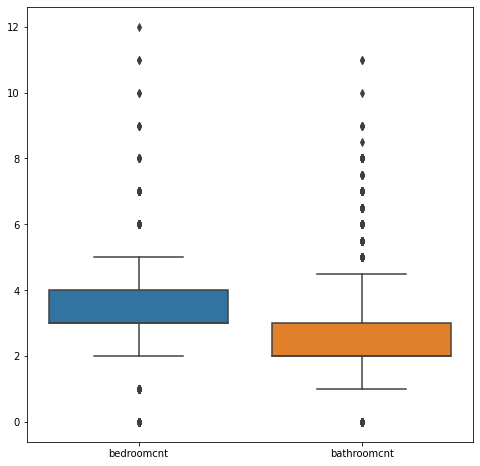

In [137]:
#vizualize the outliers
plt.figure(figsize=(8,8))
# Create boxplots for all but student_id.
sns.boxplot(data=zillow.drop(columns=['assessment_value','total_squareft']),)
plt.show()

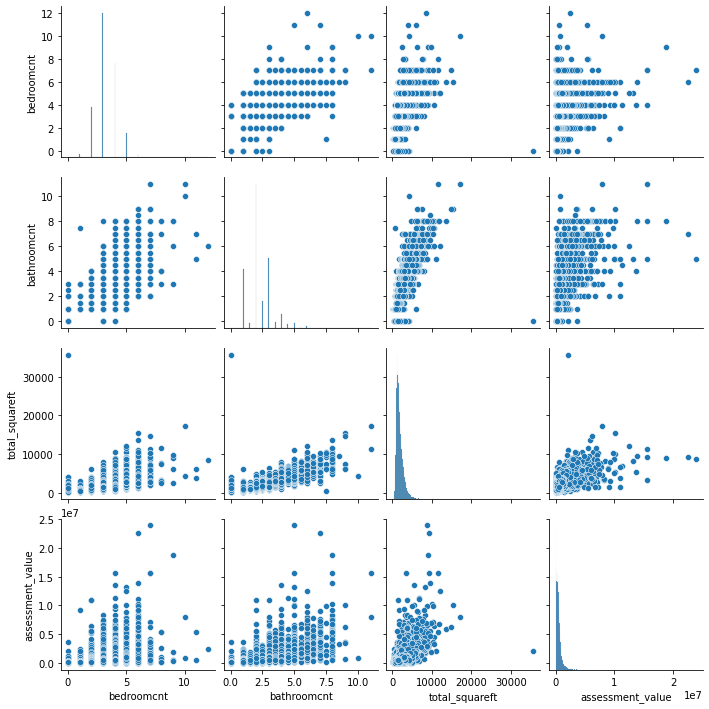

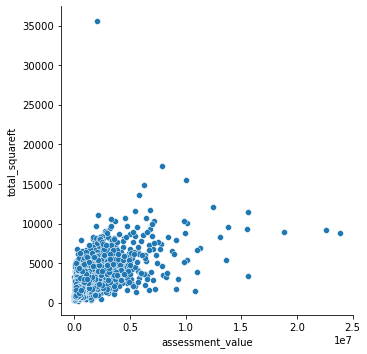

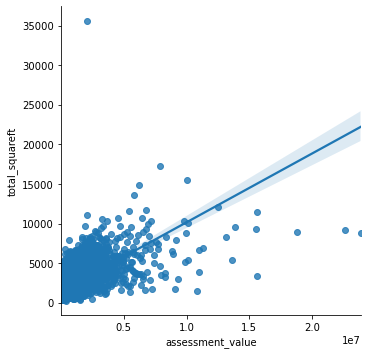

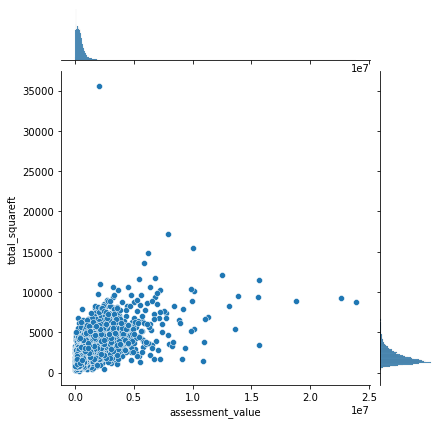

In [138]:
explore.continuous_with_continuous(zillow,'assessment_value','total_squareft', hue = None, col = None )

In [139]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28284 entries, 11721753 to 10713993
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   bedroomcnt        28284 non-null  object
 1   bathroomcnt       28284 non-null  object
 2   total_squareft    28284 non-null  int64 
 3   assessment_value  28284 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [140]:
#dropping outliers
zillow = zillow[(zillow['assessment_value'] < 1276040)& (zillow['assessment_value']>0)]
zillow = zillow[(zillow['total_squareft'] < 3882) & (zillow['total_squareft']>0)]
zillow = zillow[(zillow['bedroomcnt'] < 5.5) &  (zillow['bedroomcnt']>1.5)]
zillow = zillow[(zillow['bathroomcnt'] < 4.5) & (zillow['bathroomcnt']>0.5)]
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25179 entries, 11721753 to 10713993
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   bedroomcnt        25179 non-null  object
 1   bathroomcnt       25179 non-null  object
 2   total_squareft    25179 non-null  int64 
 3   assessment_value  25179 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 983.6+ KB


In [141]:
zillow.head()

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
parcelid,,,,
11721753,3,2,1316,205123
11289917,3,2,1458,136104
11705026,2,1,1421,35606
14269464,4,3,2541,880456
11446756,3,2,1491,107110


In [142]:
#shape of df is now 25179 records, 4 fields
zillow.shape

(25179, 4)

In [143]:
#created additional columns to represent less than and greater than with 0 and 1 value
zillow['three_or_less_bedrooms']  =  pd.cut(x=zillow['bedroomcnt'], bins=[2, 3], right = True, include_lowest = True, labels = [1]).astype('object').fillna(0).astype('int')
zillow['four_or_more_bedrooms']  =  pd.cut(x=zillow['bedroomcnt'], bins=[4, 5], right = True, include_lowest = True, labels = [1]).astype('object').fillna(0).astype('int')
zillow['three_or_more_bathrooms']  =  pd.cut(x=zillow['bedroomcnt'], bins=[3, 4], right = True, include_lowest = True, labels = [1]).astype('object').fillna(0).astype('int')
zillow['two_half_or_less_bathrooms']  =  pd.cut(x=zillow['bedroomcnt'], bins=[1, 2.5], right = True, include_lowest = True, labels = [1]).astype('object').fillna(0).astype('int')
zillow.drop(columns = ['bathroomcnt', 'bedroomcnt'], inplace = True)

In [144]:
zillow.head()


,total_squareft,assessment_value,three_or_less_bedrooms,four_or_more_bedrooms,three_or_more_bathrooms,two_half_or_less_bathrooms
parcelid,,,,,,
11721753,1316,205123,1,0,1,0
11289917,1458,136104,1,0,1,0
11705026,1421,35606,1,0,0,1
14269464,2541,880456,0,1,1,0
11446756,1491,107110,1,0,1,0


In [190]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25179 entries, 11721753 to 10713993
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_squareft              25179 non-null  int64
 1   assessment_value            25179 non-null  int64
 2   three_or_less_bedrooms      25179 non-null  int64
 3   four_or_more_bedrooms       25179 non-null  int64
 4   three_or_more_bathrooms     25179 non-null  int64
 5   two_half_or_less_bathrooms  25179 non-null  int64
dtypes: int64(6)
memory usage: 1.3 MB


In [145]:
#splitting into a train, validate and test dataset.
train, validate, test = wrangle.split_continuous(zillow)

train -> (14100, 6)
validate -> (6043, 6)
test -> (5036, 6)


### Main Takeaway:
- Doing house cleaning: dropping duplciates, dropping nans, and set parcelid to index.
- Calculated outliers for each field, dropped these outliers.
- Made some simple charts to visualize outliers
- split the zillow df into a train, validate, test datasets.
- DF shape now 25179 records and 4 fields

----------------------------------
----------------------------------

# Explore:

#### Data Exploration

##### Goal: I recommend following the exploration approach of univariate, bivariate, multivariate discussed in class. In that method, you can address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual exploration and statistical analysis. The findings from your analysis should provide you with answers to the specific questions your customer asked that will be used in your final report as well as information to move forward toward building a model.
------------------------
------------------------
#### Since my target variable is continuous, assessment_value this is a regression problem.
- important to remember that Multiple linear regression analysis makes several key assumptions:
    - There must be a linear relationship between the outcome variable and the independent variables. Scatterplots can show whether there is a linear or curvilinear relationship.
    - No Multicollinearity—Multiple regression assumes that the independent variables are not highly correlated with each other.
    - Multivariate Normality–Multiple regression assumes that the residuals are normally distributed.
----------------------------------------------

- Think about the following in this stage:

    -  Run at least 1 t-test and 1 correlation test (but as many as you need!)

    -  Visualize all combinations of variables in some way(s).

    - What independent variables are correlated with the dependent?

    - Which independent variables are correlated with other independent variables?

    - Make sure to summarize your takeaways and conclusions. That is, the Zillow data science team doesn't want to see just a bunch of dataframes, numbers, and charts without any explanation; you should explain in the notebook what these mean, interpret them.
    
    - Identitfy features that correlate with each other. If feature A and feature B are each tightly correlated with the target variable, but they're also tightly correlated with each other, we should use one feature that correlates better, rather than use both.
    - Test Your Hypotheses: Analyze the drivers of a continuous target variable using the appropriate statistical tests (t-tests, correlation, and chi-squared hypothesis tests).

In [146]:
train.head()

,total_squareft,assessment_value,three_or_less_bedrooms,four_or_more_bedrooms,three_or_more_bathrooms,two_half_or_less_bathrooms
parcelid,,,,,,
11238456,1296,100794,1,0,1,0
17273265,1308,255407,1,0,1,0
12464860,2450,133952,0,1,0,0
11201234,1562,101012,1,0,1,0
17057703,1485,997112,1,0,0,1


In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14100 entries, 11238456 to 14338873
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_squareft              14100 non-null  int64
 1   assessment_value            14100 non-null  int64
 2   three_or_less_bedrooms      14100 non-null  int64
 3   four_or_more_bedrooms       14100 non-null  int64
 4   three_or_more_bathrooms     14100 non-null  int64
 5   two_half_or_less_bathrooms  14100 non-null  int64
dtypes: int64(6)
memory usage: 771.1 KB


In [148]:
# Remember the goal here im a zillow employee 
# For the first iteration of your model, use only square feet of the home, 
# number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt.

In [149]:
cat_vars = ['bedroomcnt', 'bathroomcnt','three_or_less_bedrooms', 'four_or_more_bedrooms', 'three_or_more_bathrooms', 'two_half_or_less_bathrooms']
quant_vars = ['total_squareft','assessment_value']

## Exploring Charts

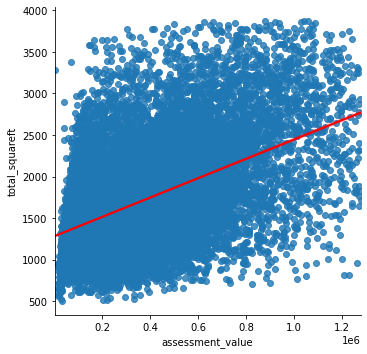

In [150]:
# there isnt really a great visible trend, an assumption can be made whiich as totalsquareft increase assessment_value increases.
sns.lmplot(x = 'assessment_value', y = 'total_squareft' , data = train, line_kws={'color': 'red'})

### Lmplot Main Takeaway:

- With the amount of data within the DF the chart is very cluttered with points. You can barely make out a trend which shows as total square ft increase so does the assessment value.
- This makes sense, the larger the square footage the greater the cost of the house. However this can be misleading without additional information. Areas can deplete a homes value even if the house is larger and also the age can result in a larger house value also being less. So remember to keep this in mind.

In [151]:
cat_vars = ['three_or_less_bedrooms', 'four_or_more_bedrooms', 'three_or_more_bathrooms', 'two_half_or_less_bathrooms']
quant_var = ['total_squareft', 'assessment_value']

<AxesSubplot:xlabel='two_half_or_less_bathrooms', ylabel='assessment_value'>

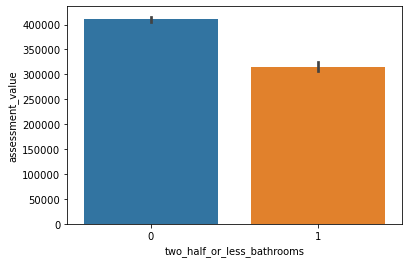

In [152]:
# can see that the tow and half baths or less have the max assessment_value
sns.barplot(x='two_half_or_less_bathrooms', y='assessment_value', data=train)

<AxesSubplot:xlabel='three_or_less_bedrooms', ylabel='assessment_value'>

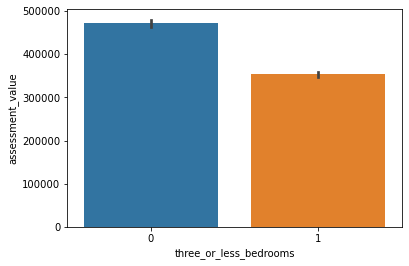

In [153]:
#greater than 3 bedrooms have the max assessment value.
sns.barplot(x='three_or_less_bedrooms', y='assessment_value', data=train)

#### Barplot takeaways:
- Can clearly see there is a trend as the number bedrooms increase as does the assessment value. 3 or more bathrooms has a larger number of high assessment values than those with less.
- Those with three or more bedrooms have more higher assessment_values than those with less than. 
    

#### Bivariate Charts

explore.explore_bivariate(train,'assessment_value', cat_vars, None)

#### Chart Main Takeways: 

- Appears to be a correlation between assessment value and totalsquare footage.
- Those 3 bathrooms or more. appear to have higher assessment values than those who dont.
- Those have more than 3 bedrooms appear to have higher assessment values than those who dont.


In [154]:
train.head()

,total_squareft,assessment_value,three_or_less_bedrooms,four_or_more_bedrooms,three_or_more_bathrooms,two_half_or_less_bathrooms
parcelid,,,,,,
11238456,1296,100794,1,0,1,0
17273265,1308,255407,1,0,1,0
12464860,2450,133952,0,1,0,0
11201234,1562,101012,1,0,1,0
17057703,1485,997112,1,0,0,1


#### Utilize Heat Map to see which features correlate the strongest with the target (assessment_value)

<AxesSubplot:title={'center':'Feautures  Correlating with assessment_value'}>

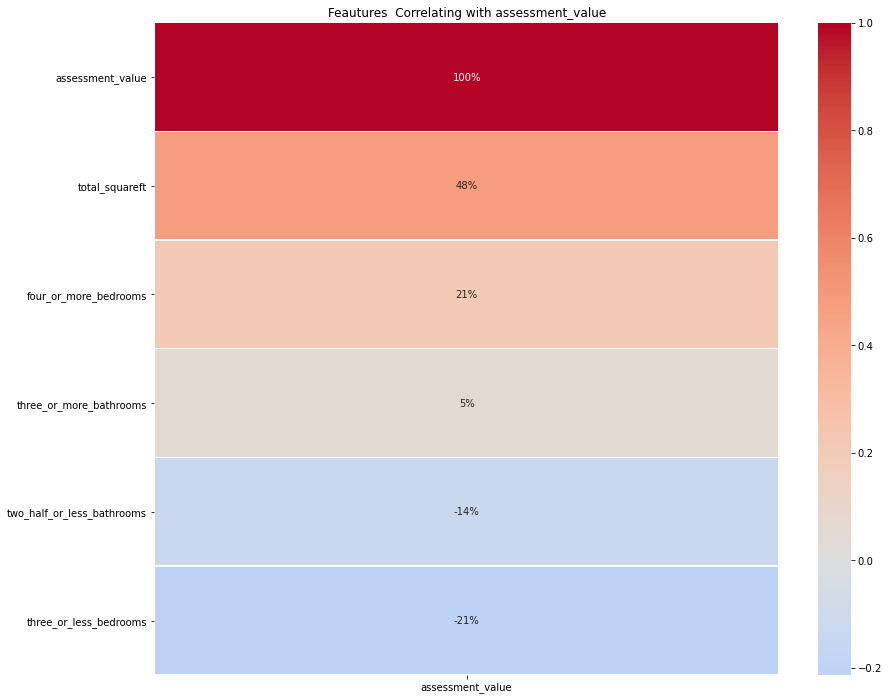

In [155]:
#strongest correlation is total_squareft, four or more bedrooms, three or more bathrooms
explore.get_heatmap(train, 'assessment_value')

### Hypothesis:

- Null: There is no relationship between the square footage of a house and assessment value. Possibly as square foot increase so does the assessment value. Contin vs contin Correlation Test.
- Null: There is no difference in the assessment values for those who have four or more bedrooms than those who dont. Categorical and continous 


 Pearson correlation coefficient is 0.48091471407251496, the corresponding p value is 0.0.
 We reject the null, and accept HA: there is a relationship between total_squareft and assessment_value


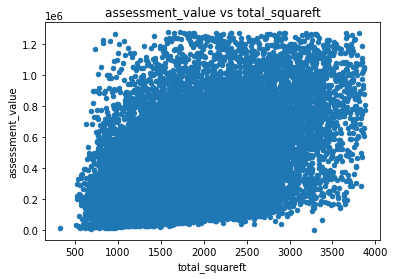

In [156]:
#Pearson Correlation

## Null: There is no relationship between the square footage of a house and assessment value. 

    
alpha = 0.05

corr, p = stats.pearsonr(zillow.total_squareft, zillow.assessment_value)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


zillow.plot.scatter('total_squareft', 'assessment_value')
plt.title('assessment_value vs total_squareft')

if p < 0.05:
    print(' We reject the null, and accept HA: there is a relationship between total_squareft and assessment_value')
else:
    print(' We accept null there is no relationship between total_squareft and assessment_value')


In [157]:
#TTest
# make a subset 
x1 = train[train.four_or_more_bedrooms == 1].assessment_value
x2 = train[train.four_or_more_bedrooms == 0].assessment_value


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no difference in the assessment values for those who have four or more bedrooms than those who dont."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = 25.9369
p_value = 0.0000

We can reject the null hypothesis that There is no difference in the assessment values for those who have four or more bedrooms than those who dont.


<AxesSubplot:xlabel='four_or_more_bedrooms', ylabel='assessment_value'>

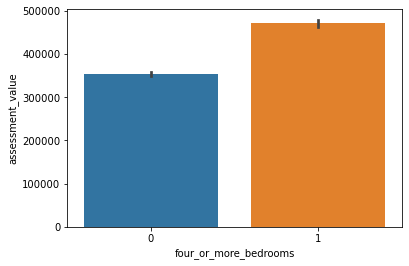

In [158]:
sns.barplot(x='four_or_more_bedrooms', y='assessment_value', data=train)

### Main Takeaways:
- We rejected the NUll hypothesis for each test.
- There is a difference in assessment values for those who have homes with >= 4 bedrooms.
- Based on the pearson coefficent and p value, we can say that there is a relationship between totalsquare_ft and assessment_value.


# Modeling:

### Need to set baseline accuracy.

About the initial baseline:

- 1.) Need to know how well we can estimate (predict) the assessment_value without using any features.Need to look at the mean or the median. 
- 2.) Try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat.


In [159]:
X_train, y_train, X_validate, y_validate, X_test, y_test = zillow_wrangle.train_validate_test(zillow, 'assessment_value', None)

In [160]:
y_test.shape, X_test.shape

((5036,), (5036, 5))

In [161]:
y_test.head()

parcelid
11279265     49237
17129558    543904
12586708    270912
11667433    163284
12815333    101018
Name: assessment_value, dtype: int64

In [162]:
# mean and median are farily similar.
y_train.mean(), y_train.median()

(393959.19141843973, 350085.0)

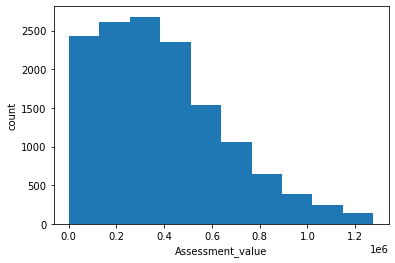

In [163]:
# Skewed right but observations greater than 30 and within 4000 dollars of each.
plt.hist(y_train)
plt.xlabel("Assessment_value")
plt.ylabel("count")
plt.show()

In [164]:
# y_train and y_validate have to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict assessment_value_pred_mean
assessment_value_pred_mean = y_train.assessment_value.mean()
y_train['assessment_value_pred_mean'] = assessment_value_pred_mean 
y_validate['assessment_value_pred_mean'] = assessment_value_pred_mean 

# 2. compute assessment_value_pred_median
assessment_value_median = y_train.assessment_value.median()
y_train['assessment_value_median'] = assessment_value_median
y_validate['assessment_value_median'] = assessment_value_median

# 3. RMSE of assessment_value_pred_mean
rmse_train = mean_squared_error(y_train.assessment_value, y_train.assessment_value_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  263663.92 
Validate/Out-of-Sample:  263244.25


In [165]:
# 4. RMSE of assessment_pred_median
rmse_train = mean_squared_error(y_train.assessment_value, y_train.assessment_value_median) ** .5
mse_validate = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  267289.37 
Validate/Out-of-Sample:  263244.25


In [166]:
y_train.head()

,assessment_value,assessment_value_pred_mean,assessment_value_median
parcelid,,,
11238456,100794,393959.191418,350085.0
17273265,255407,393959.191418,350085.0
12464860,133952,393959.191418,350085.0
11201234,101012,393959.191418,350085.0
17057703,997112,393959.191418,350085.0


In [167]:
#have stated our baseline accuracy for the model to beatr in order to be considered valid.
baseline = y_train.assessment_value.mean()
y_train['baseline'] = baseline

In [168]:
# Baseline RMSE calculation.
baseline_RMSE = math.sqrt(mean_squared_error(y_train.assessment_value, y_train.baseline))
print(f'Train RMSE Baseline {baseline_RMSE}.')

Train RMSE Baseline 263663.9232487312.


In [169]:
y_train.head()

,assessment_value,assessment_value_pred_mean,assessment_value_median,baseline
parcelid,,,,
11238456,100794,393959.191418,350085.0,393959.191418
17273265,255407,393959.191418,350085.0,393959.191418
12464860,133952,393959.191418,350085.0,393959.191418
11201234,101012,393959.191418,350085.0,393959.191418
17057703,997112,393959.191418,350085.0,393959.191418


### Model 1: Regression Model

In [170]:
# create the model object
linear_model = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
linear_model.fit(X_train, y_train.assessment_value)

# predict train
y_train['assessment_value_predict_lm'] = linear_model.predict(X_train)

# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train.assessment_value, y_train.assessment_value_predict_lm)**(1/2)

# predict validate
y_validate['assessment_value_predict_lm'] = linear_model.predict(X_validate)

# evaluate: rmse
rmse_validate_lr = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_predict_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lr, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lr)
evs_lr = explained_variance_score(y_train.assessment_value, y_train.assessment_value_predict_lm)
print('Explained Variance Linear Regression Model = ', round(evs_lr,3))

RMSE for OLS using LinearRegression
Training/In-Sample:  230956.06167951802 
Validation/Out-of-Sample:  227968.27728868957
Explained Variance Linear Regression Model =  0.233


#### Linear_regression takeaway:
- The RMSE values for the training and validate differ by ~$3000.00
- So due to the RMSE value representing dollars, I feel comfortable in saying this is an exceptable model.
- Train out performed the baseline, as did the validate, so the model is valid and useful in predicting assessment value.

### Model 2 : Polynomial

In [171]:
# make the polynomial features to get a new set of features
poly_feat = PolynomialFeatures(degree=3)

# fit and transform X_train
X_train_degree3 = poly_feat.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree3 = poly_feat.transform(X_validate)
X_test_degree3 = poly_feat.transform(X_test)


In [172]:
y_test.shape, X_test.shape, X_test_degree3.shape

((5036,), (5036, 5), (5036, 56))

In [173]:
# create the model object
linear_model3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
linear_model3.fit(X_train_degree3, y_train.assessment_value)

# predict train
y_train['assessment_predict_linear_model3'] = linear_model3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.assessment_value, y_train.assessment_predict_linear_model3)**(1/2)

# predict validate
y_validate['assessment_predict_linear_model3'] = linear_model3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_poly = mean_squared_error(y_validate.assessment_value, y_validate.assessment_predict_linear_model3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly, 
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_poly = explained_variance_score(y_train.assessment_value, y_train.assessment_predict_linear_model3)
print('Explained Variance Polynomial Model = ', round(evs_poly,3))

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  230803.69804472508 
Validation/Out-of-Sample:  227951.14520817724 
Baseline RMSE value is  263663.9232487312
Explained Variance Polynomial Model =  0.234


#### Polynomial Model Takeaway:
    
- Polynomial performed same as regression
- Model doesnt appear to be overfit.
- Model performed better than the baseline.

### Model 3: Lasso Lars 

In [174]:
# create the model object
lars_model = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars_model.fit(X_train, y_train.assessment_value)

# predict train
y_train['assessment_value_prediction_lars'] = lars_model.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.assessment_value, y_train.assessment_value_prediction_lars)**(1/2)

# predict validate
y_validate['assessment_value_prediction_lars'] = lars_model.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.assessment_value, y_validate.assessment_value_prediction_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars)
evs_lars = explained_variance_score(y_train.assessment_value, y_train.assessment_value_prediction_lars)
print('Explained Variance Linear Regression Model = ', round(evs_lars,3))

RMSE for Lasso + Lars
Training/In-Sample:  230956.70021901326 
Validation/Out-of-Sample:  227978.63911303616
Explained Variance Linear Regression Model =  0.233


#### Lasso Lars Model Takeaway:
    
- Lasso lars performed worse than the other two models
- Model performed better than the baseline.

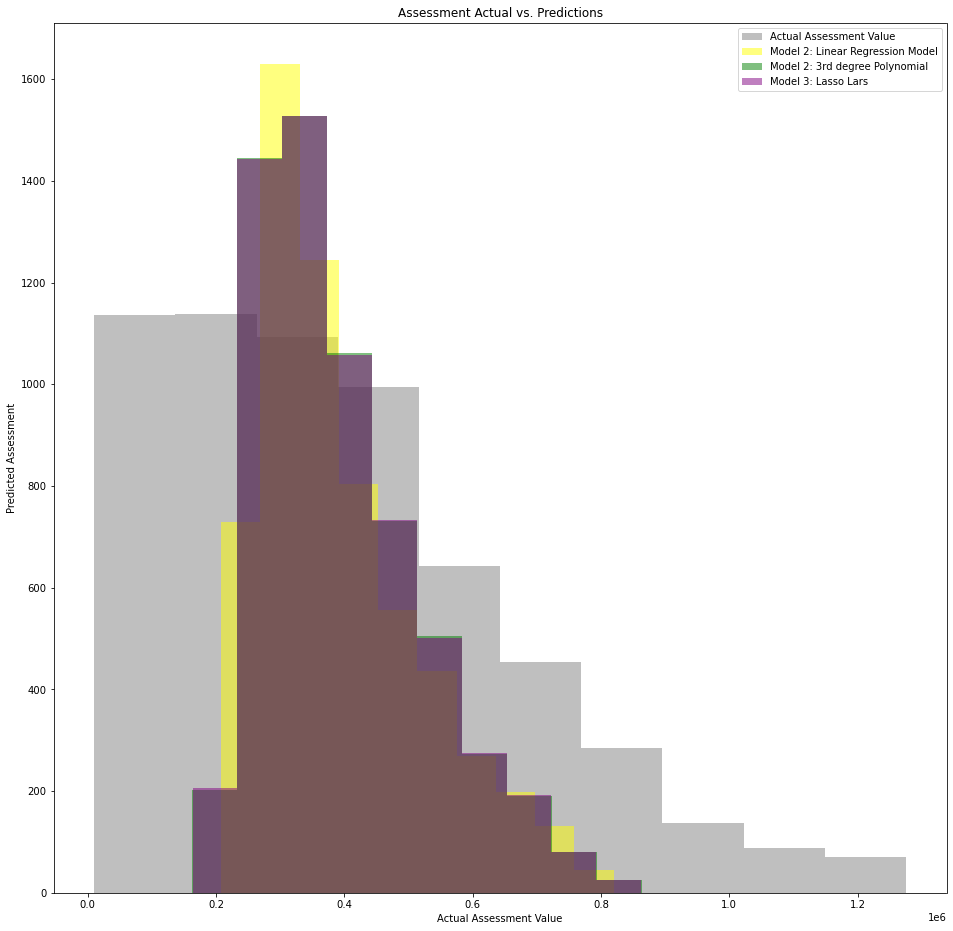

In [175]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,16))
plt.hist(y_validate.assessment_value, color='grey', alpha=.5, label="Actual Assessment Value")
plt.hist(y_validate.assessment_predict_linear_model3, alpha=.5, color="yellow", label="Model 2: Linear Regression Model")
plt.hist(y_validate.assessment_value_predict_lm, alpha=.5, color="green", label="Model 2: 3rd degree Polynomial")
plt.hist(y_validate.assessment_value_prediction_lars, alpha=.5, color="purple", label="Model 3: Lasso Lars ")
plt.xlabel("Actual Assessment Value")
plt.ylabel("Predicted Assessment")
plt.title("Assessment Actual vs. Predictions")
plt.legend()
plt.show()

#### Histo Chart Takeaway:
- The main takeaway is that polynomial is the closer fit to the actual compared to other models. 

### MVP Model Takeaways: 
- Polynomial model performed better than lasso lars and regression. Ploynomial also performed better than the baseline so the model is viable.

In [176]:
X_test_degree3.shape, y_test.shape

((5036, 56), (5036,))

# Evaluate on test dataset:

In [177]:
# create the model object
# predict train
# create dataframe
y_test = pd.DataFrame(y_test)
# use the model to make predictions
y_test['assessment_predict_poly_test'] = linear_model3.predict(X_test_degree3)

# evaluate: rmse
rmse_test_poly = mean_squared_error(y_test.assessment_value, y_test.assessment_predict_poly_test)**(1/2)


print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly, 
      "\nTest/Out-of-Sample: ", rmse_test_poly,
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_poly_test = explained_variance_score(y_test.assessment_value, y_test.assessment_predict_poly_test)
print('Explained Variance Polynomial Model = ', round(evs_poly_test,3))




RMSE for Polynomial Model, degrees=3
Training/In-Sample:  230803.69804472508 
Validation/Out-of-Sample:  227951.14520817724 
Test/Out-of-Sample:  229734.06061287798 
Baseline RMSE value is  263663.9232487312
Explained Variance Polynomial Model =  0.245


# Conclusions:

#### - Using select features to predict the assessment value of single unit properties during May 2017- Aug 2017.
#### - Utilized 5 features within model to predict assessment value.
#### - Polynomial Model had lowest RMSE value, and performed better than the baseline, so evaluated the test dataset using this model.
#### - Evaluted model on test dataset, model performed better than baseine.


## Other Deliverables:

In [183]:
#calculate TAX RATE
zillow_df['tax_rate'] = zillow_df['taxamount']/zillow_df['taxvaluedollarcnt']

In [184]:
zillow_df.fips.value_counts()

6037.0    17962
6059.0     7773
6111.0     2683
Name: fips, dtype: int64

In [185]:
#Need to create columns which have state name and county name from the fips column.
zillow_df['county_name'] = zillow_df['fips'].map({6037:'Los Angeles', 6059:'Orange', 6111:'Ventura'})
zillow_df.county_name.value_counts()

Los Angeles    17962
Orange          7773
Ventura         2683
Name: county_name, dtype: int64

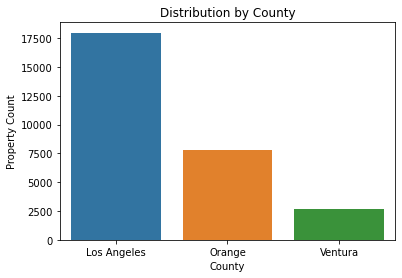

In [186]:
plt.title('Distribution by County')
sns.countplot(zillow_df.county_name)
plt.xlabel('County')
plt.ylabel('Property Count')
plt.show()

In [187]:
Chart Takeaway

SyntaxError: invalid syntax (<ipython-input-187-99f4042fa2f9>, line 1)

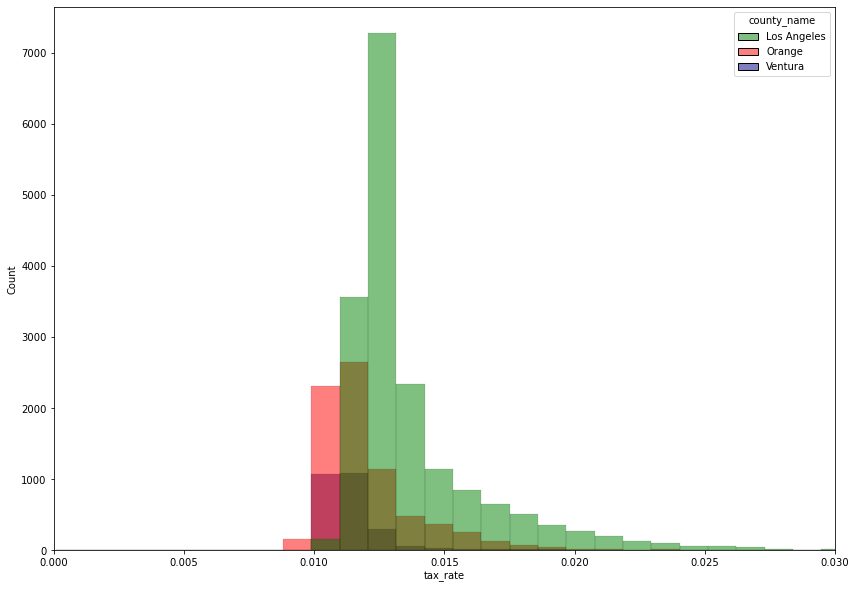

In [188]:
plt.figure(figsize=(14,10))
sns.histplot(data=zillow_df, x="tax_rate", hue="county_name",kde = False, bins = 750,  palette={'Orange':'red', 'Los Angeles':'green', 'Ventura':'navy'})
plt.xlim(0, 0.03)
plt.show()

In [189]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 11721753 to 10713993
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28418 non-null  float64
 1   bathroomcnt                   28418 non-null  float64
 2   calculatedfinishedsquarefeet  28345 non-null  float64
 3   taxvaluedollarcnt             28417 non-null  float64
 4   yearbuilt                     28322 non-null  float64
 5   taxamount                     28417 non-null  float64
 6   fips                          28418 non-null  float64
 7   tax_rate                      28416 non-null  float64
 8   county_name                   28418 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.4+ MB
